# Code for Section 3.3 Computing Simulated Risk Factors
This example shows how to compute the risk factor simulation using the simulated stationary transformations from Section 3.2.1.

The first part is the same as the accompanying code for Section 3.2.1 to avoid storing a three-dimensional matrix, but we avoid simulating conditional on different states. We just use the latest as the initial state.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Load the time series data and extract 1m ATMF implied vol state variable
time_series = ft.load_time_series()  # to extract the 1m implied vol series used as a state variable
st_df = pd.read_csv('st_df.csv', index_col=0)  # to avoid recomputing the stationary transformations from 3.1
imp_vol_1m = time_series['1m100'].iloc[1:].values


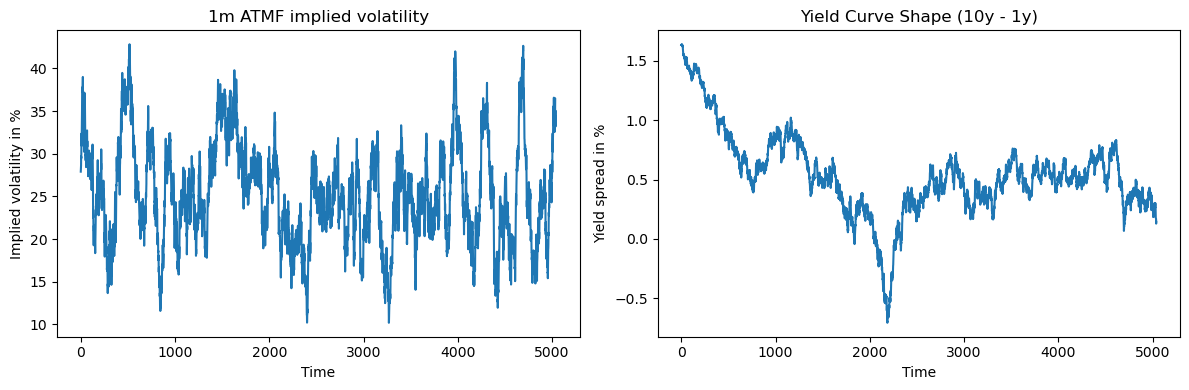

In [3]:
# Create yield curve shape variable
yield_shape = time_series['10y'] - time_series['1y']
yield_shape = yield_shape.iloc[1:].values  # Align with imp_vol_1m

# justs checiing some other columns too
cr10y= time_series['cr10y'].iloc[1:].values

# Plot original volatility
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(imp_vol_1m)
plt.title('1m ATMF implied volatility')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')

plt.subplot(1, 2, 2)
plt.plot(yield_shape)
plt.title('Yield Curve Shape (10y - 1y)')
plt.ylabel('Yield spread in %')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [4]:
# EXTENDED PARTITIONING: Volatility states
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m > imp_vol_25pct) & (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

# EXTENDED PARTITIONING: Yield curve shape states

positive_curve_indices = yield_shape >=0  # Positive/steep curve
inverted_curve_indices = yield_shape < 0   # Inverted/flat curve

In [5]:
# Create 6 combined states (3 vol × 2 yield curve)
low_vol_pos_curve = low_vol_indices & positive_curve_indices
low_vol_inv_curve = low_vol_indices & inverted_curve_indices
mid_vol_pos_curve = mid_vol_indices & positive_curve_indices
mid_vol_inv_curve = mid_vol_indices & inverted_curve_indices
high_vol_pos_curve = high_vol_indices & positive_curve_indices
high_vol_inv_curve = high_vol_indices & inverted_curve_indices

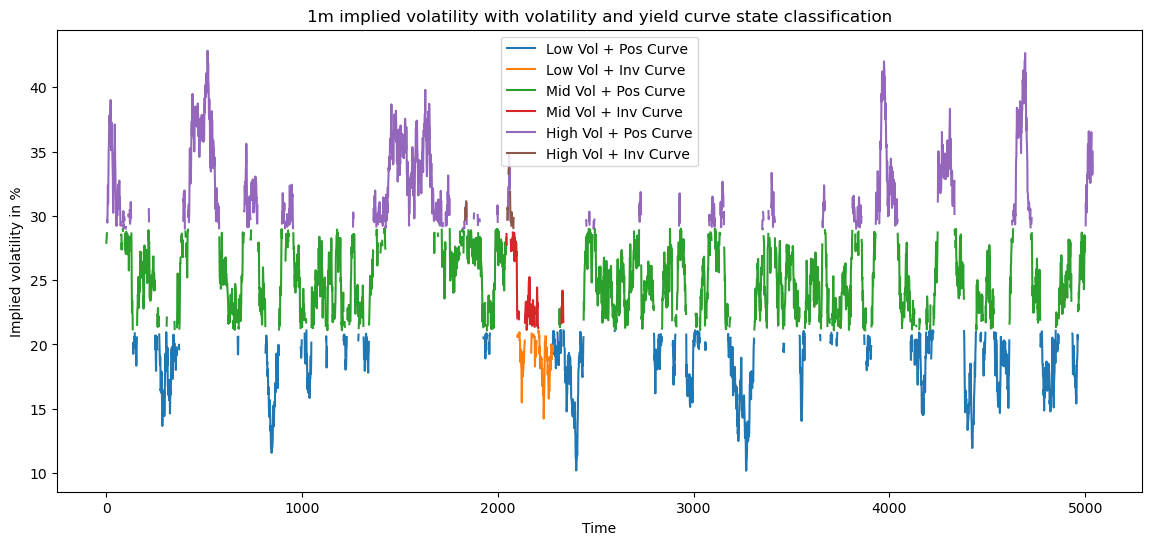

In [6]:
# Visual representation of extended partitioning
vol_low_pos = np.ma.masked_where(low_vol_pos_curve == False, imp_vol_1m)
vol_low_inv = np.ma.masked_where(low_vol_inv_curve == False, imp_vol_1m)
vol_mid_pos = np.ma.masked_where(mid_vol_pos_curve == False, imp_vol_1m)
vol_mid_inv = np.ma.masked_where(mid_vol_inv_curve == False, imp_vol_1m)
vol_high_pos = np.ma.masked_where(high_vol_pos_curve == False, imp_vol_1m)
vol_high_inv = np.ma.masked_where(high_vol_inv_curve == False, imp_vol_1m)

x = np.arange(0, len(imp_vol_1m))
plt.figure(figsize=(14, 6))
plt.plot(x, vol_low_pos, x, vol_low_inv, x, vol_mid_pos, x, vol_mid_inv, x, vol_high_pos, x, vol_high_inv)
plt.legend(['Low Vol + Pos Curve', 'Low Vol + Inv Curve', 'Mid Vol + Pos Curve', 
           'Mid Vol + Inv Curve', 'High Vol + Pos Curve', 'High Vol + Inv Curve'])
plt.title('1m implied volatility with volatility and yield curve state classification')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')
plt.show()

# Compute scenario probabilities for Fully Flexible Resampling

In [7]:
# Time conditioning (unchanged)
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

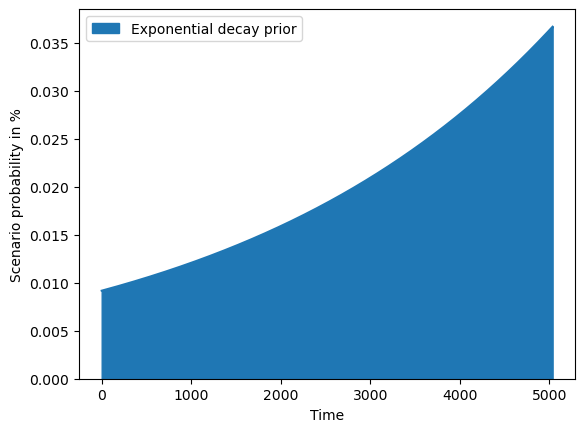

In [8]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [9]:
# Compute view values for all 6 states
states_data = {
    'low_vol_pos_curve': (low_vol_pos_curve, 'Low Vol + Pos Curve'),
    'low_vol_inv_curve': (low_vol_inv_curve, 'Low Vol + Inv Curve'),
    'mid_vol_pos_curve': (mid_vol_pos_curve, 'Mid Vol + Pos Curve'),
    'mid_vol_inv_curve': (mid_vol_inv_curve, 'Mid Vol + Inv Curve'),
    'high_vol_pos_curve': (high_vol_pos_curve, 'High Vol + Pos Curve'),
    'high_vol_inv_curve': (high_vol_inv_curve, 'High Vol + Inv Curve')
}

# Calculate statistics for each state
state_stats = {}
for state_name, (indices, description) in states_data.items():
    if np.sum(indices) > 0:  # Check if state has observations
        mu = np.mean(imp_vol_1m[indices])
        sigma = np.std(imp_vol_1m[indices])
        state_stats[state_name] = {'mu': mu, 'sigma': sigma, 'description': description}
        print(f'{description}: mean = {mu:.2f}%, std = {sigma:.2f}%, observations = {np.sum(indices)}')
    else:
        print(f'{description}: No observations in this state!')

Low Vol + Pos Curve: mean = 17.99%, std = 2.35%, observations = 1136
Low Vol + Inv Curve: mean = 18.86%, std = 1.44%, observations = 124
Mid Vol + Pos Curve: mean = 24.90%, std = 2.20%, observations = 2417
Mid Vol + Inv Curve: mean = 24.02%, std = 2.52%, observations = 102
High Vol + Pos Curve: mean = 33.04%, std = 3.17%, observations = 1238
High Vol + Inv Curve: mean = 30.54%, std = 1.37%, observations = 22


In [10]:
# Specify left hand sides for Entropy Pooling views (extended)
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
G = imp_vol_1m[:, np.newaxis].T ** 2

# Compute view constraints for all states
view_constraints = {}
probability_vectors = {}

for state_name, stats in state_stats.items():
    mu = stats['mu']
    sigma = stats['sigma']
    
    # Linear constraints (mean)
    b = np.array([[1.], [mu]])
    
    # Quadratic constraints (second moment)
    h = np.array([[sigma ** 2 + mu ** 2]])
    
    # Store constraints
    view_constraints[state_name] = {'A': A, 'b': b, 'G': G, 'h': h}
    
    # Compute Fully Flexible Resampling probability vector
    q = ft.entropy_pooling(p_exp, A, b, G, h)
    probability_vectors[state_name] = q / np.sum(q)  # Normalize

# Create combined probability matrix for visualization
state_names = list(probability_vectors.keys())
states_prob = np.column_stack([probability_vectors[name] for name in state_names])

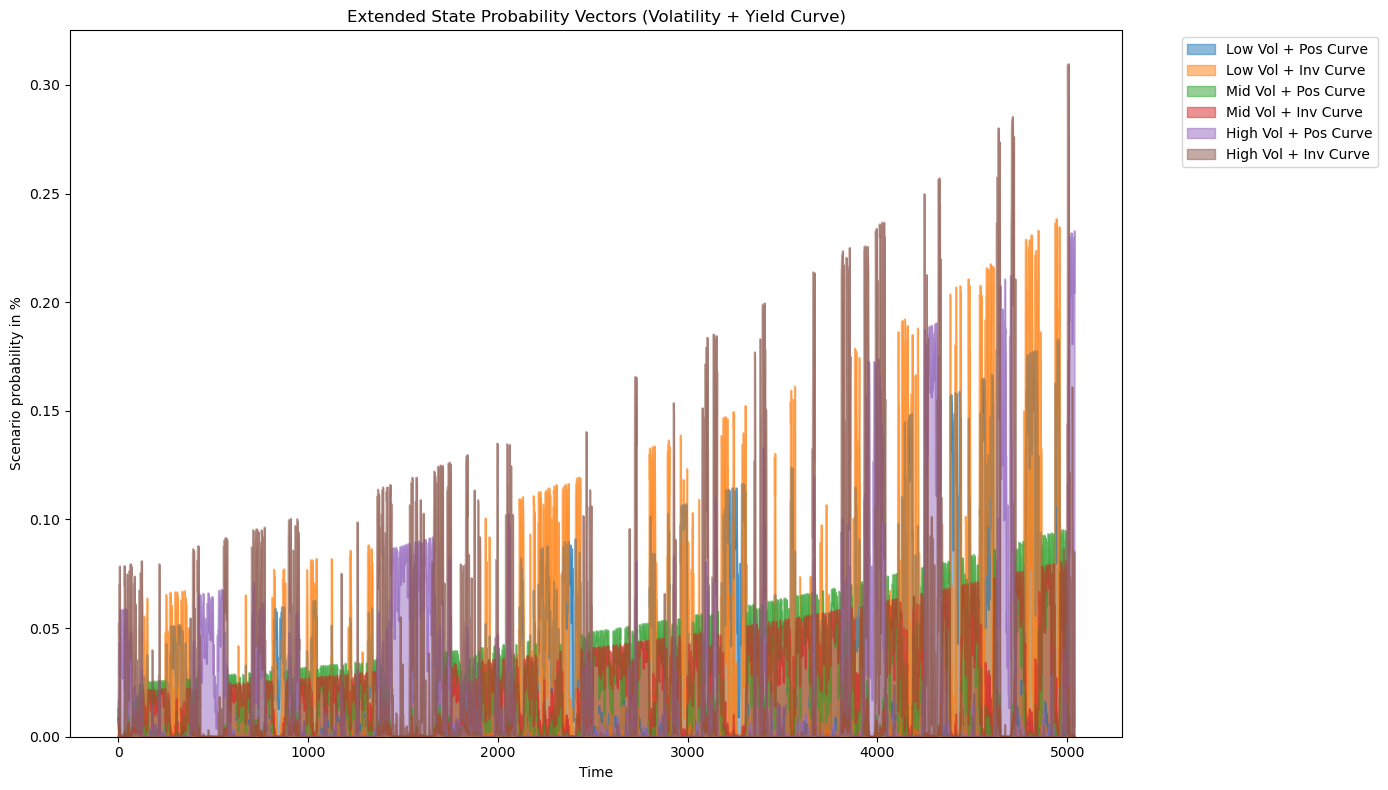

In [11]:
# Enhanced state probability visualization
column_names = [state_stats[name]['description'] for name in state_names]
pd.DataFrame(100 * states_prob, columns=column_names).plot(kind='area', stacked=False, figsize=(14, 8))
plt.title('Extended State Probability Vectors (Volatility + Yield Curve)')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
# Summary statistics table
summary_df = pd.DataFrame({
    'State': [stats['description'] for stats in state_stats.values()],
    'Mean Vol (%)': [stats['mu'] for stats in state_stats.values()],
    'Std Vol (%)': [stats['sigma'] for stats in state_stats.values()],
    'Observations': [np.sum(states_data[name][0]) for name in state_stats.keys()]
})

print("\nSummary Statistics for Extended States:")
print(summary_df.round(2))


Summary Statistics for Extended States:
                  State  Mean Vol (%)  Std Vol (%)  Observations
0   Low Vol + Pos Curve         17.99         2.35          1136
1   Low Vol + Inv Curve         18.86         1.44           124
2   Mid Vol + Pos Curve         24.90         2.20          2417
3   Mid Vol + Inv Curve         24.02         2.52           102
4  High Vol + Pos Curve         33.04         3.17          1238
5  High Vol + Inv Curve         30.54         1.37            22


Computing individual state variable probability vectors...
Computed 3 volatility state vectors
Computed 2 yield curve state vectors

Effective Number of Scenarios (ENS):
Volatility - low_vol: ENS = 1135.51
Volatility - mid_vol: ENS = 2271.63
Volatility - high_vol: ENS = 1079.94
Yield Curve - pos_curve: ENS = 4343.04
Yield Curve - inv_curve: ENS = 238.40

Diversity Scores:
Volatility - low_vol: Diversity = 0.8143
Volatility - mid_vol: Diversity = 0.7361
Volatility - high_vol: Diversity = 0.8336
Yield Curve - pos_curve: Diversity = 0.6343
Yield Curve - inv_curve: Diversity = 0.8820

COMPUTING FINAL STATE WEIGHTS
State 1 (low_vol + pos_curve):
  Vol weight: 0.2513 (ENS=1135.51, Div=0.8143)
  Curve weight: 0.7487 (ENS=4343.04, Div=0.6343)

State 2 (low_vol + inv_curve):
  Vol weight: 0.8147 (ENS=1135.51, Div=0.8143)
  Curve weight: 0.1853 (ENS=238.40, Div=0.8820)

State 3 (mid_vol + pos_curve):
  Vol weight: 0.3777 (ENS=2271.63, Div=0.7361)
  Curve weight: 0.6223 (ENS=4343.04, Div=0.6343)


<Figure size 1600x800 with 0 Axes>

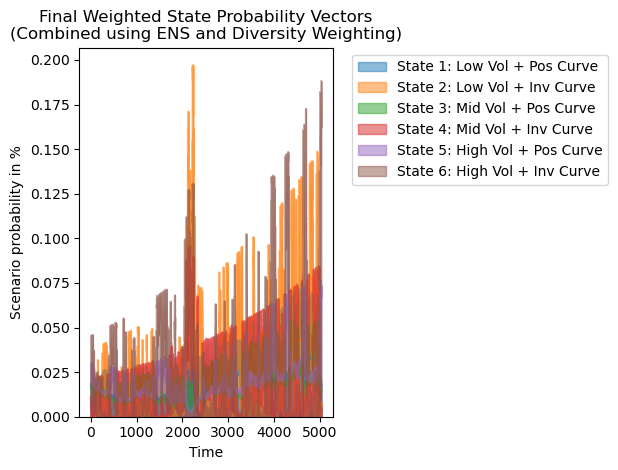

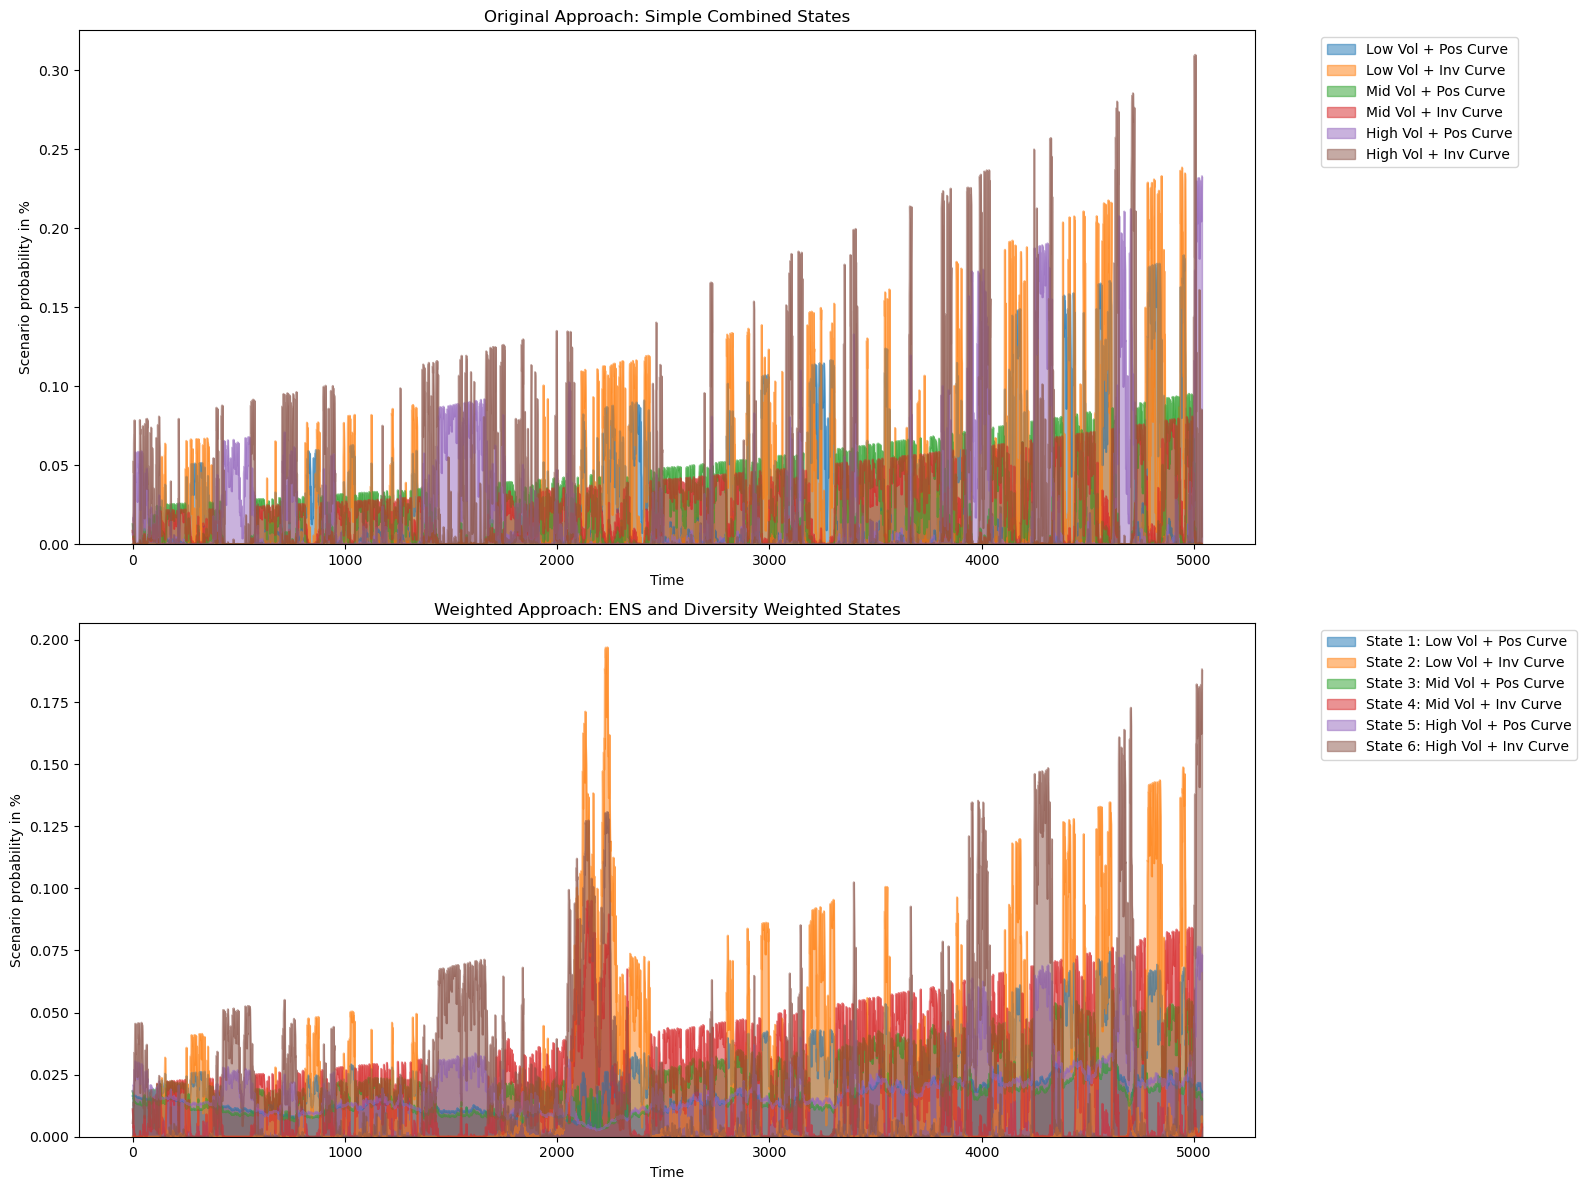


Weighting implementation complete!
Ready to proceed to simulation section with final_probability_vectors.


In [15]:
# STEP 1: Reorganize probability vectors by individual state variables
# Currently we have 6 combined states, but we need to separate them by state variable

# State Variable 1 (Volatility): I1 = 3 states
vol_states = {
    'low_vol': None,    # q1,1
    'mid_vol': None,    # q2,1  
    'high_vol': None    # q3,1
}

# State Variable 2 (Yield Curve): I2 = 2 states  
curve_states = {
    'pos_curve': None,  # q1,2
    'inv_curve': None   # q2,2
}

# We need to compute probability vectors for individual state variables
# (not the combined Cartesian product states we computed earlier)

print("Computing individual state variable probability vectors...")

# VOLATILITY STATE PROBABILITY VECTORS (m=1)
vol_constraints = {}
vol_probability_vectors = {}

# Low volatility state (im=1, m=1)
if np.sum(low_vol_indices) > 0:
    mu_vol_low = np.mean(imp_vol_1m[low_vol_indices])
    sigma_vol_low = np.std(imp_vol_1m[low_vol_indices])
    b_vol_low = np.array([[1.], [mu_vol_low]])
    h_vol_low = np.array([[sigma_vol_low ** 2 + mu_vol_low ** 2]])
    q_vol_low = ft.entropy_pooling(p_exp, A, b_vol_low, G, h_vol_low)
    vol_probability_vectors['low_vol'] = q_vol_low / np.sum(q_vol_low)

# Mid volatility state (im=2, m=1)
if np.sum(mid_vol_indices) > 0:
    mu_vol_mid = np.mean(imp_vol_1m[mid_vol_indices])
    sigma_vol_mid = np.std(imp_vol_1m[mid_vol_indices])
    b_vol_mid = np.array([[1.], [mu_vol_mid]])
    h_vol_mid = np.array([[sigma_vol_mid ** 2 + mu_vol_mid ** 2]])
    q_vol_mid = ft.entropy_pooling(p_exp, A, b_vol_mid, G, h_vol_mid)
    vol_probability_vectors['mid_vol'] = q_vol_mid / np.sum(q_vol_mid)

# High volatility state (im=3, m=1)
if np.sum(high_vol_indices) > 0:
    mu_vol_high = np.mean(imp_vol_1m[high_vol_indices])
    sigma_vol_high = np.std(imp_vol_1m[high_vol_indices])
    b_vol_high = np.array([[1.], [mu_vol_high]])
    h_vol_high = np.array([[sigma_vol_high ** 2 + mu_vol_high ** 2]])
    q_vol_high = ft.entropy_pooling(p_exp, A, b_vol_high, G, h_vol_high)
    vol_probability_vectors['high_vol'] = q_vol_high / np.sum(q_vol_high)

# YIELD CURVE STATE PROBABILITY VECTORS (m=2)
curve_probability_vectors = {}

# For yield curve, we use the same A matrix but with yield_shape as the state variable
A_curve = np.vstack((np.ones((1, T_tilde)), yield_shape))
G_curve = yield_shape[:, np.newaxis].T ** 2

# Positive curve state (im=1, m=2)
if np.sum(positive_curve_indices) > 0:
    mu_curve_pos = np.mean(yield_shape[positive_curve_indices])
    sigma_curve_pos = np.std(yield_shape[positive_curve_indices])
    b_curve_pos = np.array([[1.], [mu_curve_pos]])
    h_curve_pos = np.array([[sigma_curve_pos ** 2 + mu_curve_pos ** 2]])
    q_curve_pos = ft.entropy_pooling(p_exp, A_curve, b_curve_pos, G_curve, h_curve_pos)
    curve_probability_vectors['pos_curve'] = q_curve_pos / np.sum(q_curve_pos)

# Inverted curve state (im=2, m=2)  
if np.sum(inverted_curve_indices) > 0:
    mu_curve_inv = np.mean(yield_shape[inverted_curve_indices])
    sigma_curve_inv = np.std(yield_shape[inverted_curve_indices])
    b_curve_inv = np.array([[1.], [mu_curve_inv]])
    h_curve_inv = np.array([[sigma_curve_inv ** 2 + mu_curve_inv ** 2]])
    q_curve_inv = ft.entropy_pooling(p_exp, A_curve, b_curve_inv, G_curve, h_curve_inv)
    curve_probability_vectors['inv_curve'] = q_curve_inv / np.sum(q_curve_inv)

print(f"Computed {len(vol_probability_vectors)} volatility state vectors")
print(f"Computed {len(curve_probability_vectors)} yield curve state vectors")

# STEP 2: Compute Effective Number of Scenarios (ENS)
def compute_ens(probability_vector):
    """Compute Effective Number of Scenarios (ENS) - equation 5.1.3"""
    # ENS = 1 / sum(p_i^2)
    p = probability_vector.flatten()
    return 1 / np.sum(p ** 2)

# Compute ENS for all state vectors
ens_values = {}
print("\nEffective Number of Scenarios (ENS):")

for state_name, prob_vector in vol_probability_vectors.items():
    ens = compute_ens(prob_vector)
    ens_values[f"{state_name}_m1"] = ens
    print(f"Volatility - {state_name}: ENS = {ens:.2f}")

for state_name, prob_vector in curve_probability_vectors.items():
    ens = compute_ens(prob_vector)
    ens_values[f"{state_name}_m2"] = ens
    print(f"Yield Curve - {state_name}: ENS = {ens:.2f}")

# STEP 3: Compute Diversity Scores using Bhattacharyya coefficient and Hellinger distance
def bhattacharyya_coefficient(p1, p2):
    """Compute Bhattacharyya coefficient between two probability vectors"""
    p1 = p1.flatten()
    p2 = p2.flatten()
    return np.sum(np.sqrt(p1 * p2))

def hellinger_distance(p1, p2):
    """Compute Hellinger distance between two probability vectors"""
    b = bhattacharyya_coefficient(p1, p2)
    return np.sqrt(1 - b)

def compute_diversity_score(target_vector, all_vectors):
    """Compute diversity score as average Hellinger distance to all other vectors"""
    distances = []
    for other_vector in all_vectors:
        if not np.array_equal(target_vector.flatten(), other_vector.flatten()):
            distance = hellinger_distance(target_vector, other_vector)
            distances.append(distance)
    return np.mean(distances) if distances else 0

# Collect all probability vectors for diversity computation
all_prob_vectors = list(vol_probability_vectors.values()) + list(curve_probability_vectors.values())

# Compute diversity scores
diversity_scores = {}
print("\nDiversity Scores:")

for state_name, prob_vector in vol_probability_vectors.items():
    div_score = compute_diversity_score(prob_vector, all_prob_vectors)
    diversity_scores[f"{state_name}_m1"] = div_score
    print(f"Volatility - {state_name}: Diversity = {div_score:.4f}")

for state_name, prob_vector in curve_probability_vectors.items():
    div_score = compute_diversity_score(prob_vector, all_prob_vectors)
    diversity_scores[f"{state_name}_m2"] = div_score
    print(f"Yield Curve - {state_name}: Diversity = {div_score:.4f}")

# STEP 4: Compute final weights w_{im,m} for each combined state j
print("\n" + "="*60)
print("COMPUTING FINAL STATE WEIGHTS")
print("="*60)

# Define mapping function f_m(j) -> i_m
# J = 6 combined states, need to map each to (volatility_state, curve_state)
state_mappings = {
    0: ('low_vol', 'pos_curve'),    # j=1: low vol + positive curve
    1: ('low_vol', 'inv_curve'),    # j=2: low vol + inverted curve  
    2: ('mid_vol', 'pos_curve'),    # j=3: mid vol + positive curve
    3: ('mid_vol', 'inv_curve'),    # j=4: mid vol + inverted curve
    4: ('high_vol', 'pos_curve'),   # j=5: high vol + positive curve
    5: ('high_vol', 'inv_curve')    # j=6: high vol + inverted curve
}

# Compute weights for each combined state j
final_weights = {}
final_probability_vectors = {}

for j, (vol_state, curve_state) in state_mappings.items():
    # Get ENS and diversity for this combination
    ens_vol = ens_values.get(f"{vol_state}_m1", 0)
    ens_curve = ens_values.get(f"{curve_state}_m2", 0)
    div_vol = diversity_scores.get(f"{vol_state}_m1", 0)
    div_curve = diversity_scores.get(f"{curve_state}_m2", 0)
    
    # Compute numerator for each state variable
    numerator_vol = ens_vol * div_vol
    numerator_curve = ens_curve * div_curve
    
    # Compute weights (must sum to 1)
    total_numerator = numerator_vol + numerator_curve
    if total_numerator > 0:
        w_vol = numerator_vol / total_numerator
        w_curve = numerator_curve / total_numerator
    else:
        w_vol = 0.5
        w_curve = 0.5
    
    # Store weights
    final_weights[j] = {'w_vol': w_vol, 'w_curve': w_curve}
    
    # Compute final probability vector: q_j = w_vol * q_vol + w_curve * q_curve
    q_vol = vol_probability_vectors.get(vol_state, np.zeros((T_tilde, 1)))
    q_curve = curve_probability_vectors.get(curve_state, np.zeros((T_tilde, 1)))
    
    q_final = w_vol * q_vol + w_curve * q_curve
    q_final = q_final / np.sum(q_final)  # Normalize
    final_probability_vectors[j] = q_final
    
    print(f"State {j+1} ({vol_state} + {curve_state}):")
    print(f"  Vol weight: {w_vol:.4f} (ENS={ens_vol:.2f}, Div={div_vol:.4f})")
    print(f"  Curve weight: {w_curve:.4f} (ENS={ens_curve:.2f}, Div={div_curve:.4f})")
    print()

# STEP 5: Visualization of final weighted probability vectors
final_states_prob = np.column_stack([final_probability_vectors[j] for j in range(6)])

plt.figure(figsize=(16, 8))
state_labels = [f"State {j+1}: {state_mappings[j][0].replace('_', ' ').title()} + {state_mappings[j][1].replace('_', ' ').title()}" 
                for j in range(6)]

pd.DataFrame(100 * final_states_prob, columns=state_labels).plot(kind='area', stacked=False)
plt.title('Final Weighted State Probability Vectors\n(Combined using ENS and Diversity Weighting)')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# STEP 6: Compare original vs weighted approach
plt.figure(figsize=(16, 12))

# Original approach (top)
plt.subplot(2, 1, 1)
column_names = [state_stats[name]['description'] for name in state_names]
pd.DataFrame(100 * states_prob, columns=column_names).plot(kind='area', stacked=False, ax=plt.gca())
plt.title('Original Approach: Simple Combined States')
plt.xlabel('Time')  
plt.ylabel('Scenario probability in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Weighted approach (bottom)
plt.subplot(2, 1, 2)
pd.DataFrame(100 * final_states_prob, columns=state_labels).plot(kind='area', stacked=False, ax=plt.gca())
plt.title('Weighted Approach: ENS and Diversity Weighted States')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

print("\nWeighting implementation complete!")
print("Ready to proceed to simulation section with final_probability_vectors.")

# Simulate

In [16]:
# Create states vector using the same mapping as our weighted approach
states_vector = (0 * low_vol_pos_curve + 1 * low_vol_inv_curve +
                 2 * mid_vol_pos_curve + 3 * mid_vol_inv_curve +
                 4 * high_vol_pos_curve + 5 * high_vol_inv_curve)

# Convert boolean arrays to integers for proper state assignment
states_vector = states_vector.astype(int)

In [17]:
# Verify state assignment
print("\nState Distribution:")
for i, (state_name, (indices, description)) in enumerate(states_data.items()):
    count = np.sum(indices)
    print(f"State {i} ({description}): {count} observations ({count/len(states_vector)*100:.1f}%)")

# Define a Fully Flexible Resampling function for 6 states
def resampling_extended(S, H, initial_state, states_prob, states_vector):
    """
    Extended resampling function for 6-state system
    
    Parameters:
    S: Number of simulation paths
    H: Horizon (number of periods ahead)
    initial_state: Starting state (0-5)
    states_prob: (T_tilde x 6) matrix of state probabilities over time
    states_vector: (T_tilde,) vector indicating state at each time point
    """
    sim = np.full((S, H), -1, dtype=int)  # Initialize with -1 for debugging
    t = np.arange(len(states_vector))
    
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            # Sample time index based on current state's probability distribution
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            # Update current state based on the sampled time period
            current_state = states_vector[sim[s, h]]
    
    return sim



State Distribution:
State 0 (Low Vol + Pos Curve): 1136 observations (22.5%)
State 1 (Low Vol + Inv Curve): 124 observations (2.5%)
State 2 (Mid Vol + Pos Curve): 2417 observations (48.0%)
State 3 (Mid Vol + Inv Curve): 102 observations (2.0%)
State 4 (High Vol + Pos Curve): 1238 observations (24.6%)
State 5 (High Vol + Inv Curve): 22 observations (0.4%)


In [18]:
# Simulate historical observations with extended states
S = 10000
H = 21
np.random.seed(0)

# Use the last observed state as initial state
initial_state = states_vector[-1]
print(f"\nStarting simulation from state {initial_state}")

# Use the final weighted probability matrix instead of states_prob
sim = resampling_extended(S, H, initial_state, final_states_prob, states_vector)




Starting simulation from state 4


# Compute simulated risk factors

In [19]:
# Extract stationary transformations and compute cumulative sums
N_tilde = st_df.shape[1]
st_sim = np.full((S, N_tilde, H), np.nan)
for s in range(S):
    st_sim[s, :, :] = st_df.values[sim[s, :], :].T

st_sim_cumsum = np.cumsum(st_sim, axis=2)

print(f'The stationary transformations simulation dimension is {st_sim.shape}')

The stationary transformations simulation dimension is (10000, 79, 21)


/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(-0.3, 0.3)

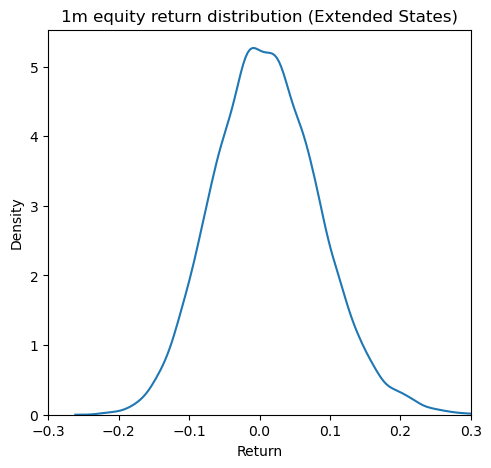

In [20]:
# Equity returns analysis
equity_returns = np.exp(st_sim_cumsum[:, 0, -1]) - 1

plt.figure(figsize=(12, 5))

# Plot 1: Distribution of equity returns
plt.subplot(1, 2, 1)
sns.kdeplot(equity_returns)
plt.title('1m equity return distribution (Extended States)')
plt.xlabel('Return')
plt.xlim([-0.3, 0.3])


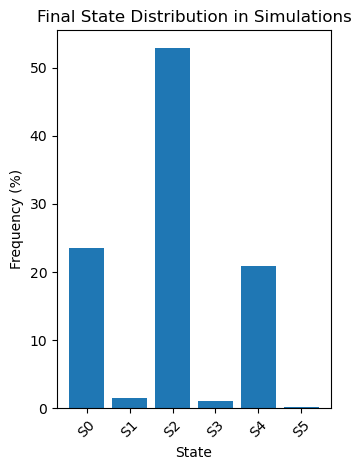


Simulation Results:
Mean equity return: 0.0109
Std equity return: 0.0750
5th percentile: -0.1069
95th percentile: 0.1380

Final State Distribution in Simulations:
State 0 (Low Vol + Pos Curve): 2349 paths (23.5%)
State 1 (Low Vol + Inv Curve): 145 paths (1.5%)
State 2 (Mid Vol + Pos Curve): 5284 paths (52.8%)
State 3 (Mid Vol + Inv Curve): 111 paths (1.1%)
State 4 (High Vol + Pos Curve): 2085 paths (20.8%)
State 5 (High Vol + Inv Curve): 26 paths (0.3%)


In [24]:
# Plot 2: State transition frequencies
plt.subplot(1, 2, 2)
final_states = states_vector[sim[:, -1]]
state_counts = np.bincount(final_states, minlength=6)
state_labels = [f'State {i}\n({list(states_data.values())[i][1]})' for i in range(6)]
plt.bar(range(6), state_counts/len(final_states)*100)
plt.title('Final State Distribution in Simulations')
plt.xlabel('State')
plt.ylabel('Frequency (%)')
plt.xticks(range(6), [f'S{i}' for i in range(6)], rotation=45)

plt.tight_layout()
plt.show()

# Additional analytics
print(f"\nSimulation Results:")
print(f"Mean equity return: {np.mean(equity_returns):.4f}")
print(f"Std equity return: {np.std(equity_returns):.4f}")
print(f"5th percentile: {np.percentile(equity_returns, 5):.4f}")
print(f"95th percentile: {np.percentile(equity_returns, 95):.4f}")

# State transition analysis
print(f"\nFinal State Distribution in Simulations:")
for i in range(6):
    count = state_counts[i]
    pct = count/len(final_states)*100
    state_desc = list(states_data.values())[i][1]
    print(f"State {i} ({state_desc}): {count} paths ({pct:.1f}%)")

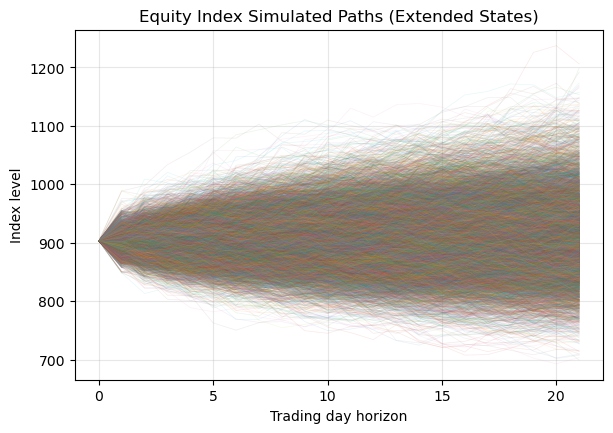

In [25]:
# Equity paths
init_vals = time_series.values[-1, :]
equity_paths = np.concatenate((np.full((S, 1), init_vals[0]),
                              np.exp(st_sim_cumsum[:, 0, :]) * init_vals[0]), axis=1)

# Enhanced visualization with state-colored paths
plt.figure(figsize=(15, 10))

# Plot 1: All simulated paths
plt.subplot(2, 2, 1)
plt.plot(equity_paths.T, alpha=0.1, linewidth=0.5)
plt.title('Equity Index Simulated Paths (Extended States)')
plt.ylabel('Index level')
plt.xlabel('Trading day horizon')
plt.grid(True, alpha=0.3)


/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/galamboslajos/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

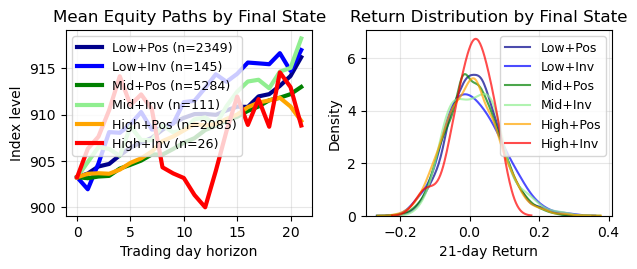


Equity Path Statistics by Final State:
----------------------------------------------------------------------
State 0 (Low+Pos):
  Paths: 2349
  Mean return: 0.0143
  Std return: 0.0728
  VaR (5%): -0.1021
  Final level range: [704, 1153]

State 1 (Low+Inv):
  Paths: 145
  Mean return: 0.0151
  Std return: 0.0801
  VaR (5%): -0.0956
  Final level range: [768, 1149]

State 2 (Mid+Pos):
  Paths: 5284
  Mean return: 0.0108
  Std return: 0.0747
  VaR (5%): -0.1061
  Final level range: [699, 1206]

State 3 (Mid+Inv):
  Paths: 111
  Mean return: 0.0165
  Std return: 0.0743
  VaR (5%): -0.0828
  Final level range: [785, 1138]

State 4 (High+Pos):
  Paths: 2085
  Mean return: 0.0067
  Std return: 0.0777
  VaR (5%): -0.1157
  Final level range: [710, 1199]

State 5 (High+Inv):
  Paths: 26
  Mean return: 0.0062
  Std return: 0.0554
  VaR (5%): -0.1000
  Final level range: [781, 984]

Overall Statistics:
Mean 21-day return: 0.0109
Volatility: 0.0750
Sharpe ratio (annualized): 0.5015
VaR (5%): -0

In [26]:
# Plot 3: State-specific path analysis
plt.subplot(2, 2, 3)
# Color paths based on their final state
state_colors = ['darkblue', 'blue', 'green', 'lightgreen', 'orange', 'red']
state_labels = ['Low+Pos', 'Low+Inv', 'Mid+Pos', 'Mid+Inv', 'High+Pos', 'High+Inv']

for state in range(6):
    state_mask = (final_states == state)
    if np.sum(state_mask) > 0:
        state_paths = equity_paths[state_mask, :]
        # Plot mean path for each state
        mean_path = np.mean(state_paths, axis=0)
        plt.plot(mean_path, color=state_colors[state], linewidth=3, 
                label=f'{state_labels[state]} (n={np.sum(state_mask)})')

plt.title('Mean Equity Paths by Final State')
plt.ylabel('Index level')
plt.xlabel('Trading day horizon')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 4: Return distribution by state
plt.subplot(2, 2, 4)
final_returns = (equity_paths[:, -1] / equity_paths[:, 0]) - 1

for state in range(6):
    state_mask = (final_states == state)
    if np.sum(state_mask) > 20:  # Only plot if sufficient observations
        state_returns = final_returns[state_mask]
        sns.kdeplot(state_returns, label=f'{state_labels[state]}', 
                   color=state_colors[state], alpha=0.7)

plt.title('Return Distribution by Final State')
plt.xlabel('21-day Return')
plt.ylabel('Density')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics by state
print(f"\nEquity Path Statistics by Final State:")
print("-" * 70)
for state in range(6):
    state_mask = (final_states == state)
    if np.sum(state_mask) > 0:
        state_paths = equity_paths[state_mask, :]
        state_returns = (state_paths[:, -1] / state_paths[:, 0]) - 1
        
        print(f"State {state} ({state_labels[state]}):")
        print(f"  Paths: {np.sum(state_mask)}")
        print(f"  Mean return: {np.mean(state_returns):.4f}")
        print(f"  Std return: {np.std(state_returns):.4f}")
        print(f"  VaR (5%): {np.percentile(state_returns, 5):.4f}")
        print(f"  Final level range: [{np.min(state_paths[:, -1]):.0f}, {np.max(state_paths[:, -1]):.0f}]")
        print()

# Overall statistics
overall_returns = (equity_paths[:, -1] / equity_paths[:, 0]) - 1
print(f"Overall Statistics:")
print(f"Mean 21-day return: {np.mean(overall_returns):.4f}")
print(f"Volatility: {np.std(overall_returns):.4f}")
print(f"Sharpe ratio (annualized): {np.mean(overall_returns) / np.std(overall_returns) * np.sqrt(252/21):.4f}")
print(f"VaR (5%): {np.percentile(overall_returns, 5):.4f}")
print(f"VaR (1%): {np.percentile(overall_returns, 1):.4f}")

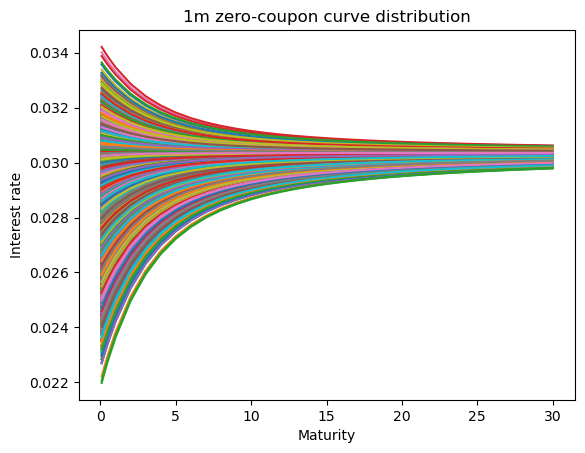

In [27]:
# Zero-coupon interest rates
maturities = np.hstack((np.array([1/12, 3/12, 6/12]), np.arange(1, 31)))
discount_factors_init = np.exp(-maturities * init_vals[1:34] / 100)
discount_factors_sim = discount_factors_init * np.exp(st_sim_cumsum[:, 1:34, -1])
interest_rates_sim = -np.log(discount_factors_sim) / maturities
plt.plot(maturities, interest_rates_sim.T)
plt.title('1m zero-coupon curve distribution')
plt.xlabel('Maturity')
plt.ylabel('Interest rate')
plt.show()

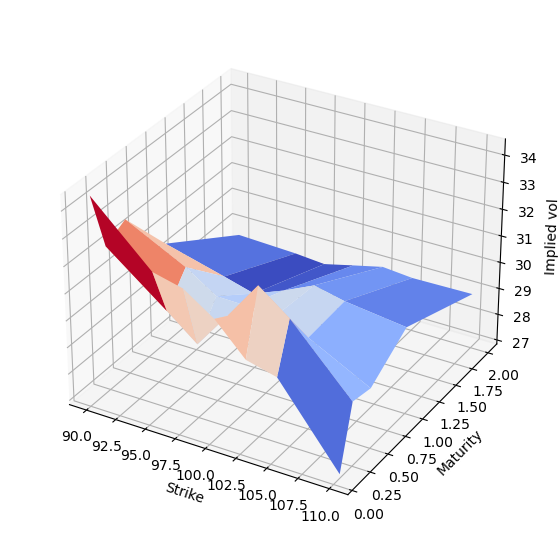

In [28]:
# Implied volatility surfaces
imp_vol_sim = init_vals[34:69] * np.exp(st_sim_cumsum[:, 34:69, -1])
ft.plot_vol_surface(1, imp_vol_sim, zoom=0.92)
plt.show()

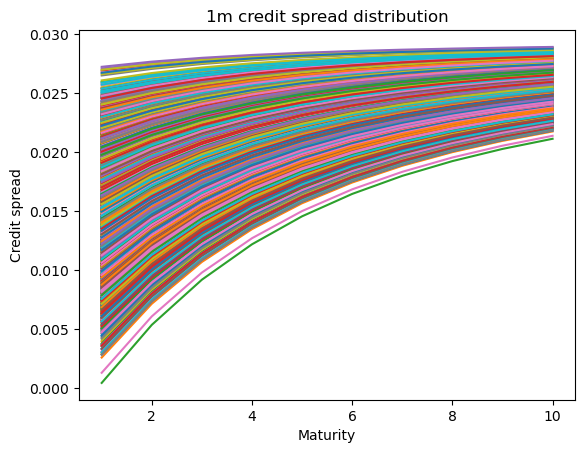

In [29]:
# Credit spreads
maturities_cr = np.arange(1, 11)
discount_factors_cr_init = np.exp(-maturities_cr * init_vals[69:] / 100)
discount_factors_cr_sim = discount_factors_cr_init * np.exp(st_sim_cumsum[:, 69:, -1])
credit_spread_sim = -np.log(discount_factors_cr_sim) / maturities_cr
plt.plot(maturities_cr, credit_spread_sim.T)
plt.title('1m credit spread distribution')
plt.xlabel('Maturity')
plt.ylabel('Credit spread')
plt.show()

In [22]:
# Save entire stationary transformation paths for Section 4.4 case study
columns = [0, 1, 37]
print(f'stationary transformations paths stored for {list(time_series.columns[columns])}.')
np.save('st_sim_cumsum', st_sim_cumsum[:, columns, :])

stationary transformations paths stored for ['Equity Index', '1m', '1m100'].


In [23]:
# Save risk factor simulation for Section 4.6 case study
risk_factor_sim = np.hstack((
    equity_returns[:, np.newaxis], interest_rates_sim, imp_vol_sim, credit_spread_sim))
print(f'Risk factor simulation shape is {risk_factor_sim.shape}. Should be (S={S}, I={time_series.shape[1]}).')

risk_factor_sim_pd = pd.DataFrame(risk_factor_sim, columns=time_series.columns)
risk_factor_sim_pd.to_csv('rf_sim.csv', index=False)

Risk factor simulation shape is (10000, 79). Should be (S=10000, I=79).


In [24]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.